# Isolated skyrmion in confined helimagnetic nanostructure

**Authors**: Marijan Beg, Marc-Antonio Bisotti, Weiwei Wang

**Date**: 26 June 2016

### Problem specification

A thin film disk sample with thickness $t=10 \,\text{nm}$ and diameter $d=150 \,\text{nm}$ is simulated. The material is FeGe with material parameters [1]:

- exchange energy constant $A = 8.78 \times 10^{-12} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 3.84 \times 10^{5} \,\text{A/m}$, and
- Dzyaloshinskii-Moriya energy constant $D = 1.58 \times 10^{-3} \,\text{J/m}^{2}$.

It is expected that when the system is initialised in the uniform out-of-plane direction $\mathbf{m}_\text{init} = (0, 0, 1)$, it relaxes to the isolated Skyrmion (Sk) state (See Supplementary Information in Ref. 1). (Note that LLG dynamics is important, which means that artificially disable the precession term in LLG may lead to other states).

### Simulation

In [1]:
from fidimag.micro import Sim
from fidimag.common import CuboidMesh
from fidimag.micro import UniformExchange, Demag, DMI

The cuboidal thin film mesh which contains the disk is created:

In [2]:
# Mesh dimensions.
d = 150  # diameter (nm)
t = 10  # thickness (nm)

# Mesh discretisation.
dx = dy  = 2.5  # nm
dz = 5

mesh = CuboidMesh(nx=int(d/dx), ny=int(d/dy), nz=int(t/dz), dx=dx, dy=dy, dz=dz, unit_length=1e-9)

Since the disk geometry is simulated, it is required to set the saturation magnetisation to zero in the regions of the mesh outside the disk. In order to do that, the following function is created:

In [3]:
def Ms_function(Ms):
    def wrapped_function(pos):
        x, y, z = pos[0], pos[1], pos[2]
    
        r = ((x-d/2.)**2 + (y-d/2.)**2)**0.5  # distance from the centre
    
        if r <= d/2:
            # Mesh point is inside the disk.
            return Ms
        else:
            # Mesh point is outside the disk.
            return 0
    return wrapped_function

To reduce the relaxation time, we define a state using a python function.

In [4]:
def init_m(pos):
    x,y,z = pos
    x0, y0 = d/2., d/2.
    r = ((x-x0)**2 + (y-y0)**2)**0.5
    
    if r<10:
        return (0,0, 1)
    elif r<30:
        return (0,0, -1)
    elif r<60:
        return (0, 0, 1)
    else:
        return (0, 0, -1)

Having the magnetisation saturation function, the simulation object can be created:

In [5]:
# FeGe material paremeters.
Ms = 3.84e5  # saturation magnetisation (A/m)
A = 8.78e-12  # exchange energy constant (J/m)
D = 1.58e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
alpha = 1  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ration (m/As)

# Create simulation object.
sim = Sim(mesh)
sim.Ms = Ms_function(Ms)
sim.alpha = alpha
sim.driver.gamma = gamma

# Add energies.
sim.add(UniformExchange(A=A))
sim.add(DMI(D=D))
sim.add(Demag())

# Since the magnetisation dynamics is not important in this stage,
# the precession term in LLG equation can be set to artificially zero.
sim.driver.do_precession = False

# Initialise the system.
sim.set_m(init_m)

Now the system is relaxed:

In [6]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
# Relax the system to its equilibrium.
sim.driver.relax(dt=1e-13, stopping_dmdt=0.01, max_steps=5000, save_m_steps=None, save_vtk_steps=None)

step=1, time=1e-13, max_dmdt=2.61e+04 ode_step=0
step=2, time=2e-13, max_dmdt=3e+04 ode_step=1.58e-14
step=3, time=3e-13, max_dmdt=3.46e+04 ode_step=2.43e-14
step=4, time=4e-13, max_dmdt=3.95e+04 ode_step=3.66e-14
step=5, time=5e-13, max_dmdt=4.43e+04 ode_step=3.66e-14
step=6, time=6e-13, max_dmdt=4.84e+04 ode_step=3.66e-14
step=7, time=7e-13, max_dmdt=5.1e+04 ode_step=3.66e-14
step=8, time=8e-13, max_dmdt=5.14e+04 ode_step=3.66e-14
step=9, time=9e-13, max_dmdt=5.05e+04 ode_step=3.66e-14
step=10, time=1e-12, max_dmdt=4.91e+04 ode_step=3.66e-14
step=11, time=1.1e-12, max_dmdt=4.63e+04 ode_step=3.66e-14
step=12, time=1.2e-12, max_dmdt=4.46e+04 ode_step=3.66e-14
step=13, time=1.3e-12, max_dmdt=4.35e+04 ode_step=3.66e-14
step=14, time=1.4e-12, max_dmdt=4.2e+04 ode_step=3.66e-14
step=15, time=1.5e-12, max_dmdt=3.99e+04 ode_step=3.66e-14
step=16, time=1.6e-12, max_dmdt=3.75e+04 ode_step=3.66e-14
step=17, time=1.7e-12, max_dmdt=3.46e+04 ode_step=3.66e-14
step=18, time=1.8e-12, max_dmdt=3.17e+

The magnetisation components of obtained equilibrium configuration can be plotted in the following way:

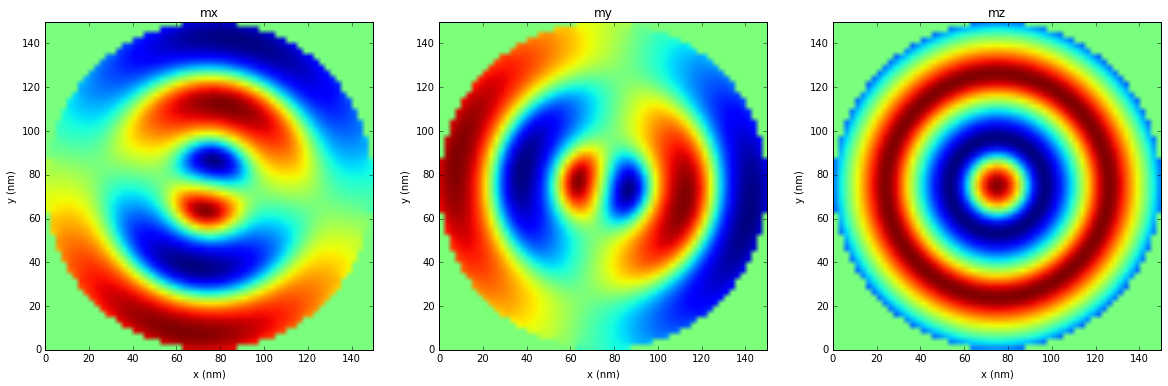

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_magnetisation(m, layer=0):
    n_layer = int(d/dx) * int(d/dy)
    m.shape = (-1, 3)
    
    mx = m[:, 0][layer*n_layer:(layer+1)*n_layer]
    my = m[:, 1][layer*n_layer:(layer+1)*n_layer]
    mz = m[:, 2][layer*n_layer:(layer+1)*n_layer]
    mx.shape = (int(d/dx), int(d/dy))
    my.shape = (int(d/dx), int(d/dy))
    mz.shape = (int(d/dx), int(d/dy))
    
    extent = [0, d, 0, d]
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(mx, extent=extent)
    plt.title('mx')
    plt.xlabel('x (nm)')
    plt.ylabel('y (nm)')
    plt.subplot(1, 3, 2)
    plt.imshow(my, extent=extent)
    plt.xlabel('x (nm)')
    plt.ylabel('y (nm)')
    plt.title('my')
    plt.subplot(1, 3, 3)
    plt.imshow(mz, extent=extent)
    plt.xlabel('x (nm)')
    plt.ylabel('y (nm)')
    plt.title('mz')
    
plot_magnetisation(sim.spin, layer=0)

### References

[1] Beg, M. et al. Ground state search, hysteretic behaviour, and reversal mechanism of skyrmionic textures in confined helimagnetic nanostructures. *Sci. Rep.* **5**, 17137 (2015).